# Sentiment Analysis using BERT

In [1]:
import torch

# check if gpu is avaibale
if torch.cuda.is_available():
    device = torch.device("cuda")
torch.device(0)

device(type='cuda', index=0)

# Load BERT

In [2]:
from transformers import BertModel, BertTokenizerFast

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# download pretrained model
bert = BertModel.from_pretrained("bert-base-uncased")
print(bert)

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [4]:
# define tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)

In [5]:
# example of tokenizer encoding
text = "Jim Henson was a puppeteer"

sent_id = tokenizer.encode(
    text,
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    max_length=10, # define max secuence lenght
    truncation=True,
    pad_to_max_length='right' # pad tokens to the right
)
print("Integer secuence: {}".format(sent_id))

Integer secuence: [101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]


/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


* 101: [CLS] token
* 102: [SEP] token
* 0: [PAD] token

In [6]:
# convert integers back to sequence
print("Tokenized text: {}".format(tokenizer.convert_ids_to_tokens(sent_id)))

# Decode to see the original not tokenized
print("Decoded sequence: {}".format(tokenizer.decode(sent_id)))

Tokenized text: ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']
Decoded sequence: [CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


In [7]:
# understand inputs and outputs
att_mask = [int(tok>0) for tok in sent_id]
# convert to tensors ids and attention mask
sent_id = torch.tensor(sent_id)
att_mask = torch.tensor(att_mask)

# reshape in form of (batch, text_lenght)
sent_id = sent_id.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)

# reshaped tensor
print(sent_id)

tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


In [8]:
# pass tensors to BERT
outputs = bert(sent_id, attention_mask=att_mask)
# hidden states at eacht timestep
all_hidden_states = outputs[0]
# hidden states at first timestep ([CLS] token)
cls_hidden_state = outputs[1]

print(all_hidden_states.shape, cls_hidden_state.shape)

torch.Size([1, 10, 768]) torch.Size([1, 768])


# Data preparation

In [9]:
import re
import sys
import pandas as pd

sys.path.append('..')
from utils.s3_class import S3Functions

s3_funcs = S3Functions(bucket_name='jdgallegoq-sentiment-analysis')

In [10]:
# load data
df = pd.read_csv(s3_funcs.read_object(key='bert/Tweets.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [11]:
# targets distribution
print(df.airline_sentiment.value_counts())
# by proportion
print(df.airline_sentiment.value_counts(normalize=True))

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


In [12]:
class_counts = df.airline_sentiment.value_counts().to_list()

In [13]:
# text cleaning
def text_preprocess(text):
    # lowercase
    text = text.lower()
    # remove mentions
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # remove hashtags
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # remove links
    text = re.sub(r'http\S+', '', text)
    # split tokens to remove extra spaces
    tokens = text.split()

    return ' '.join(tokens)


In [14]:
# applyt function and clean text
df['clean_text'] = df['text'].apply(text_preprocess)

In [15]:
# separate text and labels
text = df['clean_text'].values
labels = df['airline_sentiment'].values

In [16]:
from sklearn.preprocessing import LabelEncoder

# preprare output
le = LabelEncoder()
labels = le.fit_transform(labels)

# classes
print(le.classes_)
# labels
print(labels)

['negative' 'neutral' 'positive']
[1 2 1 ... 1 0 1]


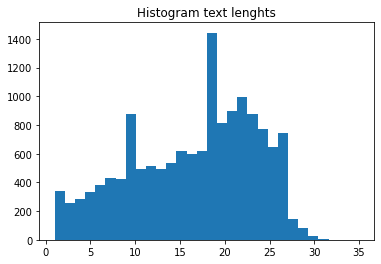

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# preprare inputs
num_words = [len(t.split()) for t in text]
plt.hist(num_words, bins=30)
plt.title('Histogram text lenghts')
plt.show()

In [18]:
# define max lenght looking to have max num of tweets
max_len = 26 

In [19]:
from tqdm import tqdm

In [20]:
# sent ids list
sent_id = []
for i in tqdm(range(len(text))):
    encoded_sent = tokenizer.encode(
        text[i],
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        pad_to_max_length='right'
    )
    sent_id.append(encoded_sent)

  0%|          | 0/14640 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable /opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 14640/14640 [00:01<00:00, 12478.31it/s]


In [21]:
# create attention masks
attention_masks = []
for sent in tqdm(sent_id):
    att_mask = [int(tok>0) for tok in sent]
    attention_masks.append(att_mask)

100%|██████████| 14640/14640 [00:00<00:00, 515927.09it/s]


In [22]:
# train and test splits
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    sent_id,
    labels,
    random_state=5132024,
    test_size=0.1,
    stratify=labels
)
# repeat for masks
train_masks, val_masks, _ ,_ = train_test_split(
    attention_masks,
    labels,
    random_state=5132024,
    test_size=0.1,
    stratify=labels
)

In [23]:
# create dataloaders
# inputs
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
# labels
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
# masks
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [24]:
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler
)

In [25]:
# define batch size. recommended {16, 32}
batch_size = 32

# dataloader for train
train_data = TensorDataset(train_inputs, train_masks, train_labels)
# define sampler.
# Random: smaples randomly
# Sequential: samples sequentially, always in the same order
train_sampler = RandomSampler(train_data)
# represent all of it in an iterator
train_dataloader = DataLoader(
    train_data,
    sampler=train_sampler,
    batch_size=batch_size
)

# same for val
val_data = TensorDataset(val_inputs, val_masks, val_labels)
# define sampler.
# Random: smaples randomly
# Sequential: samples sequentially, always in the same order
val_sampler = SequentialSampler(val_data)
# represent all of it in an iterator
val_dataloader = DataLoader(
    val_data,
    sampler=val_sampler,
    batch_size=batch_size
)

# define iterator
#iterator = iter(train_dataloader)
# loads batch data
#sent_id, mask, target = next(iterator)

# Model finetunning
Finetune Head only. Steps:
1. Turn off gradients (cause we're going to finetune Head only)
2. Define model architecture
3. Define optimizer and loss
4. Define train and evaluate.
5. Train model
6. Evaluate model

In [26]:
import numpy as np
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight

In [27]:
# 1. turn off gradients
for param in bert.parameters():
    param.requires_grad = False

In [28]:
# 2. define model architecture.
class classifier(nn.Module):

    def __init__(self, bert):
        super(classifier, self).__init__()

        self.bert = bert
        # dense 1
        self.fc1 = nn.Linear(768, 512)
        # dense 2 (output layer, 3 cells as 3 labels avaiable)
        self.fc2 = nn.Linear(512, 3)
        # dropout
        self.dropout = nn.Dropout(0.1)
        # activation function
        self.relu = nn.ReLU()
        # softmax activation (to get probas)
        self.softmax = nn.LogSoftmax(dim=1)

    # define forward pass
    def forward(self, sent_id, mask):
        # pass inputs to the models
        all_hidden_states, cls_hidden_state = self.bert(
            sent_id,
            attention_mask=mask,
            return_dict=False
        )
        # pass CLS hidden state to dense layer
        x = self.fc1(cls_hidden_state)
        # apply ReLU
        x = self.relu(x)
        # apply dropout
        x = self.dropout(x)
        # pass input to the output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)

        return x

In [29]:
model = classifier(bert)
if torch.cuda.is_available():
    model = model.to(device)
model

classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [30]:
# count model trainable params
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_params(model)

395267

In [31]:
# optimizer and loss
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [32]:
# as classes are unbalanced, then calculate weights for each class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
print("Class weights: ", class_weights)

# then pass it as tensors
weights = torch.tensor(class_weights, dtype=torch.float)

# transfer to gpu is available
if torch.cuda.is_available():
    weights = weights.to(device)

# cross-entropy
cross_entropy = nn.NLLLoss(weight=weights)

Class weights:  [0.53170625 1.57470152 2.06517139]


In [33]:
# model train
def train():
    print("\nTraining")
    # set model to training phase
    model.train()
    # initialize loss and accuracy to 0
    total_loss, total_accuracy = 0, 0
    # list for preds
    total_preds = []

    # loop over train batches
    for step, batch in enumerate(train_dataloader):
        # push batch to GPU
        if torch.cuda.is_available():
            batch = tuple(t.to(device) for t in batch)
        else:
            batch = tuple(t for t in batch)
        
        # unpack batch tensors
        sent_id, mask, labels = batch

        # reset gradient optimization. Pytorch does not do it automatically
        model.zero_grad()
        # forward
        preds = model(sent_id, mask)
        # loss
        loss = cross_entropy(preds, labels)
        # accumulate it. Access the tensor value by doing .item()
        total_loss = total_loss + loss.item()

        # perform backward to calculate gradients
        loss.backward()
        # optimize gradients
        optimizer.step()
        #if torch.cuda.is_available():
        preds = preds.detach().cpu().numpy()
        
        # accumulate model preds
        total_preds.append(preds)
    
    # compute training loss of a epoch
    avg_loss = total_loss / len(train_dataloader)
    # rehsape preds [batches, batch_size, classes] -> [samples, classes]
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [34]:
# eval
def evaluate():
    print("\nEvaluating...")

    # set the model on evaluating phase - dropout layers deactivated
    model.eval()

    # initialize loss and accuracy
    total_loss, total_accuracy = 0, 0

    # create an empty list to save model preds
    total_preds = []

    # loop over batches
    for step, batch in enumerate(val_dataloader):
        if torch.cuda.is_available():
            batch = tuple(t.to(device) for t in batch)
        else:
            batch = tuple(t for t in batch)

        # unpack tensors
        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            # forward
            preds = model(sent_id, mask)
            # compute val loss
            loss = cross_entropy(preds, labels)
            # accumulate loss
            total_loss = total_loss + loss.item()
            # pass preds to cpu
            #if torch.cuda.is_available():
            preds = preds.detach().cpu().numpy()
            # accumulate preds at each batch
            total_preds.append(preds)

    # compute val loss of an epoch
    avg_loss = total_loss / len(val_dataloader)
    # reshape preds
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds 


In [35]:
# train process in action
best_valid_loss = float('inf')

# empty list for train and val losses
train_losses = []
val_losses = []

epochs = 5

for epoch in range(epochs):
    print('\n....... epoch {:} / {:} .......'.format(epoch + 1, epochs))

    # train
    train_loss, _ = train()
    # eval
    val_loss, _ = evaluate()

    # save best model
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), '../module/models/bert_save_weights.pt')
    
    # accumulate training and validation loss
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {val_loss:.3f}')

print('\nTraining complete!')


....... epoch 1 / 5 .......

Training

Evaluating...

Training Loss: 0.980
Validation Loss: 0.963

....... epoch 2 / 5 .......

Training

Evaluating...

Training Loss: 0.843
Validation Loss: 0.824

....... epoch 3 / 5 .......

Training

Evaluating...

Training Loss: 0.790
Validation Loss: 0.736

....... epoch 4 / 5 .......

Training

Evaluating...

Training Loss: 0.767
Validation Loss: 0.688

....... epoch 5 / 5 .......

Training

Evaluating...

Training Loss: 0.761
Validation Loss: 0.704

Training complete!


In [36]:
# load model weights
path = "../module/models/bert_save_weights.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [37]:
valid_loss, preds = evaluate()
print(valid_loss)


Evaluating...


In [39]:
# convert
y_pred = np.argmax(preds, axis=1)
y_true = val_labels

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       918
           1       0.57      0.49      0.53       310
           2       0.54      0.80      0.65       236

    accuracy                           0.73      1464
   macro avg       0.66      0.70      0.67      1464
weighted avg       0.75      0.73      0.74      1464

